#### Capstone - # Capstone Project - Find the best location to open a car wash center (Week 2)
### Applied Data Science Capstone by IBM/Coursera

* [1.Introduction: Business problem](#introduction)
* [2.Data](#data)
* [3. Methodology](#methodology)
* [4. Results](#results)
* [5. Results and discussion](#results)
* [6. Conclusion](#conclusion)

## 1.Introduction: Business problem <a name="introduction"></a>

Starting a car wash business can be a interesting, and profitable business. With the right location, and top-notch service, you can draw in numerous customers who need their cars washed quickly, efficiently, and at a good price. Considering this, In this project we will find a best location to open a Car wash center. This project is targeted for the stackholders/Business people who wants to open a **Car wash center**.
 

 1. **Find the existing car wash centers in the entire toronto city**. 
 2. **Find the boroughs which has dense population and less car wash centers**.
 3. **Analyse the nearby venues of the existing car wash centers to find which is the better location for new car wash center**.
 4. **From selected boroughs, Find the neighbourhoods which dont have any car wash centre . So that stake holder can select a location from these neighbourhoods which have more common venues near to it.**
 

## 2.Data <a name='data'></a>

a) Toronto city neighborhood information is scraped from this link
 https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
 
b) The boroughs which has more **population** is gathered from https://en.wikipedia.org/wiki/Demographics_of_Toronto.

c) Geographical information is required to explore the neighborhoods. This is information taken from **Geospatial_Coordinates.csv**

d) Using Foursquare API calls to get the nearest venues**(Car wash center)** of neighborhoods.

#### Install the required packages 

In [9]:
!pip install beautifulsoup4

     |████████████████████████████████| 112kB 8.9MB/s eta 0:00:01


#### Import the packages 

In [10]:
import requests               # To get the web page (response)
import pandas as pd           # For Data analysis
import numpy as np            # For vector operations
import sys                    
import math 
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup # For Web scraping
from pandas.io.json import json_normalize #to convert json format to data frame

#### Web scrapping, Data wrangling 

##### Get the neighborhoods of toronto 

In [11]:
def get_toronto_neighborhoods(): 
    url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    neighborhoods = soup.find('table', attrs={'class': 'wikitable sortable'})
    
    rows = neighborhoods.find_all('tr')
    data = []

    cols = rows[0].find_all('th')
    headers = [ele.text.strip() for ele in cols]

    for row in rows[1:]:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele])
        
    neighborhoods = pd.DataFrame(data, columns=headers)   
    neighborhoods.rename(columns={'Neighborhood':'Neighbourhood'}, inplace=True)
    neighborhoods['Postcode'] = neighborhoods['Postcode'].astype(str)
    print(neighborhoods.dtypes)
    neighborhoods = cleanNeighborhoods(neighborhoods)
    neighborhoods = mergeAllDuplicatePostalCodes(neighborhoods)
    return neighborhoods

#### Clean the neighbourhoods. 
##### 1.Remove the boroughs which have value "Not assigned".
##### 2.Remove the neighbourhoods for which boroughs are "Not assigned".

In [12]:
#Clean the neighborhood data which was received from the web page
def cleanNeighborhoods(neighborhoods):
    neighborhoods = neighborhoods[neighborhoods['Borough']!="Not assigned"].reset_index(drop=True)
    for ind in range(len(neighborhoods)):
        if (neighborhoods.loc[ind, "Neighbourhood"] == "Not assigned"):
            neighborhoods.at[ind, 'Neighbourhood'] = neighborhoods.loc[ind, "Borough"] 
            
    return neighborhoods

#### Merge the boroughs which has same postal code by combining the neighbourhoods 

In [13]:
#merge all duplicate postal code, because the lotitude and longitude values are same for those neighborhoods
def mergeAllDuplicatePostalCodes(neighborhoods):
    dict = {} #postal code, neighborhood list
    
    #Store the neighborhoods of unique postal code in dictionary
    for ind in range(len(neighborhoods)):
        if (neighborhoods.loc[ind, "Postcode"] not in dict.keys()):
            dict[neighborhoods.loc[ind, "Postcode"]] = []
        dict[neighborhoods.loc[ind, "Postcode"]].append(neighborhoods.loc[ind, "Neighbourhood"])
    
    #Drop the duplicate postal code rows and keep the first row in the duplicates
    neighborhoods.drop_duplicates(subset="Postcode", keep='first', inplace = True)
    neighborhoods.reset_index(inplace=True, drop=True)

    for k, v in dict.items() :
        combined_nws = ','.join(v)
        ind = neighborhoods.index[neighborhoods['Postcode']==k]
        neighborhoods.at[ind, 'Neighbourhood'] = combined_nws # needs to be replaced with iat/at 
  
    return neighborhoods

In [14]:
neighborhoods = get_toronto_neighborhoods()
#neighborhoods.to_csv('neighbourhoods.csv')

Postcode         object
Borough          object
Neighbourhood    object
dtype: object


#### Read Geospatial_Coordinates.csv
##### 1. Read the latitude and longitude information from the Geospatial_Coordinates.csv
##### 2. Add the latitude and longitude information to the neighbourhoods data frame.

In [15]:
def addLongLatToNeighborhoods(neighborhoods):
    geo_df = pd.read_csv("Geospatial_Coordinates.csv")
    longlat_dict = {}
    lat=[]
    long=[]
    for code, lt, ln in zip(geo_df['Postal Code'], geo_df['Latitude'], geo_df['Longitude']):
        longlat_dict[code] = [lt,ln]

    for code in neighborhoods['Postcode']:
        lonlat = longlat_dict[code]
        lat.append(lonlat[0])
        long.append(lonlat[1])
    neighborhoods['Latitude'] = lat 
    neighborhoods['Longitude'] = long
    return neighborhoods

In [16]:
neighborhoods = addLongLatToNeighborhoods(neighborhoods)
#neighborhoods.to_csv('neighbourhoods.csv')

### View the existing car wash centers using folium map 

#### Foursquare credentials 

In [17]:
CLIENT_ID = 'HQFIE2LGCMTESBTMPHN23QEPWMUYLRZDZ3AMZD4FWF5Z3QJA' # your Foursquare ID
CLIENT_SECRET = 'FAYQ2B50PC42VERLNA1MDG0HWDKMKRPC4ZAVJREEBDD13HEM' # your Foursquare Secret
VERSION = '20191210' # Foursquare API version

#### Get the existing **Car wash centers** within 10km radius of the neighbourhoods

In [18]:
def get_existing_carwash_centers_by_search(neighborhoods, radius = 10000):
    limit =100 
    car_wash = '4f04ae1f2fb6e1c99f3db0ba'
    
    venues_list =[]
    for borough, name, lat, long in zip(neighborhoods['Borough'],neighborhoods['Neighbourhood'], neighborhoods['Latitude'], neighborhoods['Longitude']):
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&limit={}&radius={}&categoryId={}'.format(
                CLIENT_ID,CLIENT_SECRET, lat, long, VERSION, limit, radius, car_wash)
        
        response = requests.get(url).json()
        response = response['response']['venues']
        
        venues_list.append([(borough,name, venue['name'], 
                          venue['id'],
                          venue['categories'][0]['name'], 
                          venue['location']['lat'],
                          venue['location']['lng']) for venue in response])
    car_wash_centers = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    car_wash_centers.columns = ['Borough', 'Neighbourhood', 'Venue', 'Venue_id','Category', 'Location.lat', 'Location.lng']
    return car_wash_centers

In [19]:
def get_existing_carwash_centers_by_search_1(neighborhoods, radius = 10000):
    limit =100 
    car_wash = '4f04ae1f2fb6e1c99f3db0ba'
    
    venues_list =[]
    for borough, name, lat, long in zip(neighborhoods['Borough'],neighborhoods['Neighbourhood'], neighborhoods['Latitude'], neighborhoods['Longitude']):
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&limit={}&radius={}&categoryId={}'.format(
                CLIENT_ID,CLIENT_SECRET, lat, long, VERSION, limit, radius, car_wash)
        
        response = requests.get(url).json()
        response = response['response']['venues']
      
        venues_list.append([(venue['name'], 
                             venue['id'],
                             venue['categories'][0]['name'], 
                             venue['location']['lat'],
                             venue['location']['lng']) for venue in response])
        
    car_wash_centers = pd.DataFrame([item for venue_list in venues_list for item in venue_list])  
    car_wash_centers.columns = ['Venue', 'Venue_id','Category', 'Location.lat', 'Location.lng']
 
    return car_wash_centers

In [20]:
exsiting_carwash_centers = get_existing_carwash_centers_by_search_1(neighborhoods)  # pd.read_csv('exsiting_carwash_centers.csv', index_col=0) #
#exsiting_carwash_centers.to_csv('exsiting_carwash_centers.csv')

In [21]:
exsiting_carwash_centers.shape

(4413, 5)

#### Remove the duplicates from the existing car wash centers data frame and create the unique car wash centers data frame. 

In [22]:
exsiting_carwash_centers_unqiue = exsiting_carwash_centers.drop_duplicates(subset=['Venue_id'], keep ='first')
exsiting_carwash_centers_unqiue.reset_index(drop=True, inplace=True)
exsiting_carwash_centers_unqiue

,Venue,Venue_id,Category,Location.lat,Location.lng
0,Petro-Canada,4c361e9118e72d7fca4714f5,Gas Station,43.757950,-79.315187
1,Petro-Canada,4c1aab3ee9c4ef3bad7f45aa,Gas Station,43.819847,-79.326214
2,Petro-Canada,4b940518f964a520dc6134e3,Gas Station,43.800817,-79.296738
3,Petro-Canada,4d3f1dc83ec9a35df6916081,Gas Station,43.775024,-79.333001
4,Mr Shine,517bd64b498e8b8341545f1c,Car Wash,43.768606,-79.386297
...,...,...,...,...,...
186,Canadian Tire Gas+,4cef2ff20acea35dc43aedae,Gas Station,43.604246,-79.588673
187,In 'N Out Coin Wash,4f67be6ae4b037b43e46c413,Car Wash,43.723058,-79.718145
188,In N Out Car Wash,4c0bb886340720a160798893,Car Wash,43.754805,-79.709485
189,Shell Car Wash,5722a31f498ee93a2413b41f,Car Wash,43.570520,-79.660093


In [23]:
#exsiting_carwash_centers_unqiue.to_csv('exsiting_carwash_centers_unqiue.csv')

In [24]:
exsiting_carwash_centers_unqiue.shape

(191, 5)

#### Find the neighbourhood of the existing car wash centre, Since foursquare API doesn't provide proper information about neighbourhood

In [25]:
def getNeighbourhoodsAndBoroughs(exsiting_carwash_centers_unqiue, neighborhoods): 
    neighbourhood_list = []
    boroughs_list = []
    for vlat,vlng in zip(exsiting_carwash_centers_unqiue['Location.lat'],exsiting_carwash_centers_unqiue['Location.lng']):
        min_distance = sys.float_info.max
        v_neighbourhood = None
        v_borough =None

        for borough, neighbourhood, nlat, nlng in zip(neighborhoods['Borough'], neighborhoods['Neighbourhood'],neighborhoods['Latitude'],neighborhoods['Longitude']):
            d = distance(vlat, nlat, vlng, nlng)
            if min_distance > d : 
                min_distance = d
                v_neighbourhood = neighbourhood  
                v_borough = borough
        #print(d, v_neighbourhood,v_borough )
        neighbourhood_list.append(v_neighbourhood)
        boroughs_list.append(v_borough)
    exsiting_carwash_centers_unqiue['Borough'] = boroughs_list
    exsiting_carwash_centers_unqiue['Neighbourhood'] = neighbourhood_list
    return exsiting_carwash_centers_unqiue

In [26]:
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2): 
    lon1 = radians(lon1) 
    lon2 = radians(lon2) 
    lat1 = radians(lat1) 
    lat2 = radians(lat2) 
       
    dlon = lon2 - lon1  
    dlat = lat2 - lat1 
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  
    c = 2 * asin(sqrt(a))  
    return c 

In [27]:
existing_carwash_centers_unqiue = getNeighbourhoodsAndBoroughs(exsiting_carwash_centers_unqiue, neighborhoods)
existing_carwash_centers_unqiue = existing_carwash_centers_unqiue[['Borough', 'Neighbourhood','Venue', 'Venue_id','Category', 'Location.lat', 'Location.lng']]
existing_carwash_centers_unqiue

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Borough,Neighbourhood,Venue,Venue_id,Category,Location.lat,Location.lng
0,North York,Parkwoods,Petro-Canada,4c361e9118e72d7fca4714f5,Gas Station,43.757950,-79.315187
1,Scarborough,L'Amoreaux West,Petro-Canada,4c1aab3ee9c4ef3bad7f45aa,Gas Station,43.819847,-79.326214
2,Scarborough,L'Amoreaux West,Petro-Canada,4b940518f964a520dc6134e3,Gas Station,43.800817,-79.296738
3,North York,"Fairview,Henry Farm,Oriole",Petro-Canada,4d3f1dc83ec9a35df6916081,Gas Station,43.775024,-79.333001
4,North York,"Silver Hills,York Mills",Mr Shine,517bd64b498e8b8341545f1c,Car Wash,43.768606,-79.386297
...,...,...,...,...,...,...,...
186,Etobicoke,"Alderwood,Long Branch",Canadian Tire Gas+,4cef2ff20acea35dc43aedae,Gas Station,43.604246,-79.588673
187,Etobicoke,Northwest,In 'N Out Coin Wash,4f67be6ae4b037b43e46c413,Car Wash,43.723058,-79.718145
188,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",In N Out Car Wash,4c0bb886340720a160798893,Car Wash,43.754805,-79.709485
189,Mississauga,Canada Post Gateway Processing Centre,Shell Car Wash,5722a31f498ee93a2413b41f,Car Wash,43.570520,-79.660093


#### Folium map of existing car wash centers 

In [29]:
#Toronto latitude longitude
import folium # map rendering library

latitude = 43.666667
longitude= -79.416667 
map_toronto = folium.Map(location =[latitude, longitude], zoom_start=12)

for neighbourhood, lat, lng in zip(existing_carwash_centers_unqiue['Neighbourhood'], existing_carwash_centers_unqiue['Location.lat'], existing_carwash_centers_unqiue['Location.lng']):
    label = '{}'.format(neighbourhood)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup = folium.Popup(label, parse_html=True), 
        color='blue',
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,      
        parse_html=False).add_to(map_toronto) 
map_toronto

## 3.Methodology <a name='methodology'></a>

The analysis has to be done on the prepared data to find the best location . The first step is to find the boroughs which has dense population and less car centers. Let's analyse the data and figure that out.

#### Group the car wash centers based on the boroughs and find the number of car wash centers per borough

In [30]:
existing_carwash_centers_grouped = existing_carwash_centers_unqiue.groupby('Borough').count().reset_index()
existing_carwash_centers_grouped.sort_values('Category', ascending=True, inplace=True)
existing_carwash_centers_grouped.reset_index(inplace=True, drop=True)
existing_carwash_centers_grouped

,Borough,Neighbourhood,Venue,Venue_id,Category,Location.lat,Location.lng
0,Central Toronto,1,1,1,1,1,1
1,Queen's Park,1,1,1,1,1,1
2,East York,3,3,3,3,3,3
3,West Toronto,5,5,5,5,5,5
4,East Toronto,6,6,6,6,6,6
5,York,6,6,6,6,6,6
6,Downtown Toronto,11,11,11,11,11,11
7,Mississauga,26,26,26,26,26,26
8,Etobicoke,29,29,29,29,29,29
9,Scarborough,49,49,49,49,49,49


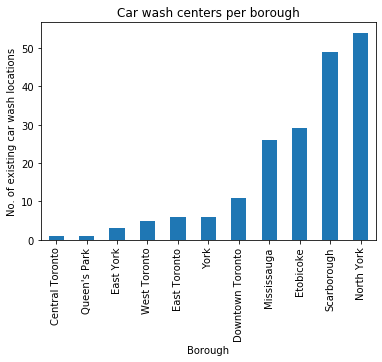

In [31]:
indexless_df = existing_carwash_centers_grouped.set_index('Borough')
indexless_df['Category'].plot(kind='bar')
plt.ylabel('No. of existing car wash locations')
plt.title('Car wash centers per borough')
plt.show()

As per the bar graph, the bouroughs **North York and Scarborough** has more car wash centers than any other boroughs. So we can skip these boroughs. The boroughs **East toronto, East York, Queens park, West toronto, York, Central toronto** are smallers bouroughs. So the best location would be  **Downtown toronto,Etobicoke, Mississauga** to open a new car wash center. 

Since we have indentified the boroughs, Now we have to analyse the near by venues of the existing car centers to find what are the common near by venues for the existing car wash centers. 

### View the car wash centers in map by boroughs 
In the map, 
1. **North York and Scarborough** are marked in Red colour
2. **Downtown toronto, Etobicoke, Mississauga** are marked in Green colour.
3. Others are marked in Yellow colour.

In [32]:
#Toronto latitude longitude
import folium # map rendering library

def get_colour(borough):
    if borough in ['North York', 'Scarborough']:
        return 'red'
    if borough in ['Etobicoke', 'Mississauga','Downtown Toronto']:
        return 'green'
    if borough in ["Queen's Park", "York", "West Toronto","East Toronto","East York" ,"Central Toronto"]:
        return 'yellow'
    return 'blue'


latitude = 43.666667
longitude= -79.416667 
nearest_venue = folium.Map(location =[latitude, longitude], zoom_start=12)

for borough, neighbourhood, lat, lng in zip(existing_carwash_centers_unqiue['Borough'],existing_carwash_centers_unqiue['Neighbourhood'], existing_carwash_centers_unqiue['Location.lat'], existing_carwash_centers_unqiue['Location.lng']):
    label = '{}'.format(neighbourhood)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup = folium.Popup(label, parse_html=True), 
        color= get_colour(borough),
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,      
        parse_html=False).add_to(nearest_venue) 
   
    #label = folium.Popup(label,max_width=450, parse_html=True)
nearest_venue

#### Get the near by venues of each car wash center of toronto city, And analyse where exactly these car centers are located and find the commonality of them. 

In [33]:
def getNearbyVenues(vid, names, latitudes, longitudes, radius=500):
    venues_list=[]
    for vid,name, lat, lng in zip(vid, names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            30)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(vid,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Venue_id', 
                             'Venue',
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Nearby Venue',
                             'Nearby Venue Category']
    
    return(nearby_venues)

In [34]:
nearByVenues = getNearbyVenues(existing_carwash_centers_unqiue['Venue_id'], 
                               existing_carwash_centers_unqiue['Venue'],
                               existing_carwash_centers_unqiue['Location.lat'],
                               existing_carwash_centers_unqiue['Location.lng']) 
#nearByVenues.to_csv('nearByVenues.csv')

In [35]:
nearByVenues = pd.read_csv('nearByVenues.csv', index_col=0)

In [36]:
nearByVenues.groupby('Venue_id').count()

,Venue,Venue Latitude,Venue Longitude,Nearby Venue,Nearby Venue Category
Venue_id,,,,,
4b37b3bff964a520aa4425e3,15,15,15,15,15
4b4a0abbf964a520c37826e3,12,12,12,12,12
4b51d59cf964a5204f5727e3,6,6,6,6,6
4b5aedfff964a520c2da28e3,28,28,28,28,28
4b5f6524f964a520d8b729e3,28,28,28,28,28
...,...,...,...,...,...
5c054216b77c77002c09f3b0,30,30,30,30,30
5c2150b3ee7120002cf9cc28,24,24,24,24,24
5c843fd486bc49003902b312,6,6,6,6,6


#### Create dummies for near by venues, for applying machine learning algorithm.

In [37]:
# Convert the dummies
nearByVenues_dummies = pd.get_dummies(nearByVenues[['Nearby Venue Category']], prefix="", prefix_sep="")

# add venues column back to dataframe
nearByVenues_dummies['Venue_id'] = nearByVenues['Venue_id'] 

# move venues column to the first column
fixed_columns = [nearByVenues_dummies.columns[-1]] + list(nearByVenues_dummies.columns[:-1])
nearByVenues_dummies = nearByVenues_dummies[fixed_columns]

nearByVenues_dummies.head()

,Venue_id,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,4c361e9118e72d7fca4714f5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4c361e9118e72d7fca4714f5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4c361e9118e72d7fca4714f5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4c361e9118e72d7fca4714f5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4c361e9118e72d7fca4714f5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
nearByVenues_grouped = nearByVenues_dummies.groupby('Venue_id').mean().reset_index()
nearByVenues_grouped

,Venue_id,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,4b37b3bff964a520aa4425e3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
1,4b4a0abbf964a520c37826e3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
2,4b51d59cf964a5204f5727e3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
3,4b5aedfff964a520c2da28e3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035714,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
4,4b5f6524f964a520d8b729e3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,...,0.000000,0.000000,0.000000,0.035714,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,5c054216b77c77002c09f3b0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.033333,0.0,0.0,0.000000
187,5c2150b3ee7120002cf9cc28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.041667,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
188,5c843fd486bc49003902b312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
189,5d5ed8c63c6e63000740edb6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.033333,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.033333


#### Lets see the near by common venues of car wash center in common

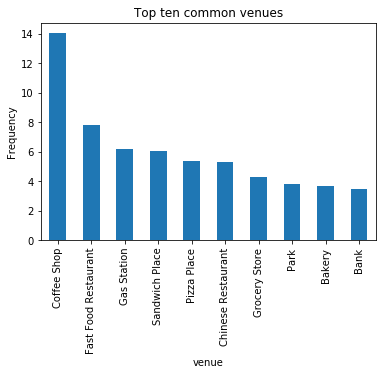

In [39]:
top_dataFrame = pd.DataFrame()
for venue in nearByVenues_grouped['Venue_id']:
    temp = nearByVenues_grouped[nearByVenues_grouped['Venue_id'] == venue].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:] 
    temp['freq'] = temp['freq'].astype(float)
    #temp = temp.round({'freq': 2})
    top_dataFrame= top_dataFrame.append(temp)
top_dataFrame.columns = ['venue','freq']
top_dataFrame = top_dataFrame.groupby('venue').sum()
top_dataFrame.sort_values('freq', ascending=False, inplace=True)

top_venues_near_car_wash_center = top_dataFrame.iloc[0:10]
top_venues_near_car_wash_center['freq'].plot(kind='bar')
plt.ylabel('Frequency')
plt.title('Top ten common venues')
plt.show()


##### These are the top locations near by the car wash centers. 

#### By applying the clustering algorithm on the data, We can obtain the most common group where the car wash center is located.

##### Get the top venues near each car wash center and create a data frame.

In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [41]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Venue_id']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
nearby_venues_sorted = pd.DataFrame(columns=columns)
nearby_venues_sorted['Venue_id'] = nearByVenues_grouped['Venue_id']

for ind in np.arange(nearByVenues_grouped.shape[0]):
    nearby_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nearByVenues_grouped.iloc[ind, :], num_top_venues)

nearby_venues_sorted.shape

(191, 11)

#### Apply K means algorithm to get the clusters based on near by locations. 

In [42]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

nearByVenues_grouped_clustering = nearByVenues_grouped.drop('Venue_id', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nearByVenues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 4, 0, 0, 0, 4], dtype=int32)

In [43]:
# add clustering labels
nearby_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nearby_venues_merged = existing_carwash_centers_unqiue

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nearby_venues_merged = nearby_venues_merged.join(nearby_venues_sorted.set_index('Venue_id'), on='Venue_id')

nearby_venues_merged # check the last columns!

,Borough,Neighbourhood,Venue,Venue_id,Category,Location.lat,Location.lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,Parkwoods,Petro-Canada,4c361e9118e72d7fca4714f5,Gas Station,43.757950,-79.315187,0,Coffee Shop,Bowling Alley,Breakfast Spot,Bank,Sushi Restaurant,Supermarket,Beer Store,Liquor Store,Spa,Bus Line
1,Scarborough,L'Amoreaux West,Petro-Canada,4c1aab3ee9c4ef3bad7f45aa,Gas Station,43.819847,-79.326214,4,Chinese Restaurant,Bubble Tea Shop,Asian Restaurant,Shopping Mall,Fast Food Restaurant,Sandwich Place,Supermarket,Dumpling Restaurant,Szechuan Restaurant,Ramen Restaurant
2,Scarborough,L'Amoreaux West,Petro-Canada,4b940518f964a520dc6134e3,Gas Station,43.800817,-79.296738,4,Chinese Restaurant,Pizza Place,Coffee Shop,Shopping Mall,Gas Station,Grocery Store,Noodle House,Pharmacy,Dance Studio,Dumpling Restaurant
3,North York,"Fairview,Henry Farm,Oriole",Petro-Canada,4d3f1dc83ec9a35df6916081,Gas Station,43.775024,-79.333001,0,Middle Eastern Restaurant,Chinese Restaurant,Coffee Shop,Gym / Fitness Center,Pub,Electronics Store,Eastern European Restaurant,Sandwich Place,Gym,Jewelry Store
4,North York,"Silver Hills,York Mills",Mr Shine,517bd64b498e8b8341545f1c,Car Wash,43.768606,-79.386297,0,Coffee Shop,Café,Clothing Store,Park,Supermarket,Chinese Restaurant,Tea Room,Bank,Furniture / Home Store,Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,Etobicoke,"Alderwood,Long Branch",Canadian Tire Gas+,4cef2ff20acea35dc43aedae,Gas Station,43.604246,-79.588673,0,Vietnamese Restaurant,Fast Food Restaurant,BBQ Joint,Department Store,Korean Restaurant,Sandwich Place,Light Rail Station,Supermarket,Laser Tag,Portuguese Restaurant
187,Etobicoke,Northwest,In 'N Out Coin Wash,4f67be6ae4b037b43e46c413,Car Wash,43.723058,-79.718145,0,Convenience Store,Café,Bar,Gas Station,Pub,Yoga Studio,Farmers Market,Ethiopian Restaurant,Event Space,Falafel Restaurant
188,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",In N Out Car Wash,4c0bb886340720a160798893,Car Wash,43.754805,-79.709485,3,Dance Studio,Coffee Shop,Gas Station,Yoga Studio,Fast Food Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market
189,Mississauga,Canada Post Gateway Processing Centre,Shell Car Wash,5722a31f498ee93a2413b41f,Car Wash,43.570520,-79.660093,4,Chinese Restaurant,Asian Restaurant,Supermarket,Mediterranean Restaurant,Furniture / Home Store,Spa,Sandwich Place,Pizza Place,Noodle House,Korean Restaurant


#### Analyse the clusters 

In [44]:
cluster_df = nearby_venues_merged.groupby('Cluster Labels').count()
cluster_df 

nearby_venues_merged.to_csv('nearby_venues_merged.csv')

In [45]:
cnt = pd.DataFrame(nearby_venues_merged['Cluster Labels'].value_counts())
cnt.rename(columns={'Cluster Labels':'Value counts'}, inplace=True)
cnt.index.name = 'Cluster Labels'
cnt

,Value counts
Cluster Labels,
0,153
4,26
3,8
1,3
2,1


#### Cluster 0

In [46]:
nearby_venues_merged.loc[nearby_venues_merged['Cluster Labels'] == 0, nearby_venues_merged.columns[[1] + list(range(5,nearby_venues_merged.shape[1]))]]

,Neighbourhood,Location.lat,Location.lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,43.757950,-79.315187,0,Coffee Shop,Bowling Alley,Breakfast Spot,Bank,Sushi Restaurant,Supermarket,Beer Store,Liquor Store,Spa,Bus Line
3,"Fairview,Henry Farm,Oriole",43.775024,-79.333001,0,Middle Eastern Restaurant,Chinese Restaurant,Coffee Shop,Gym / Fitness Center,Pub,Electronics Store,Eastern European Restaurant,Sandwich Place,Gym,Jewelry Store
4,"Silver Hills,York Mills",43.768606,-79.386297,0,Coffee Shop,Café,Clothing Store,Park,Supermarket,Chinese Restaurant,Tea Room,Bank,Furniture / Home Store,Restaurant
5,Church and Wellesley,43.672840,-79.387528,0,Italian Restaurant,Coffee Shop,Gourmet Shop,Café,Shopping Mall,Thai Restaurant,Furniture / Home Store,French Restaurant,Lounge,Spa
6,Cedarbrae,43.782135,-79.234784,0,Hotel,Bakery,Coffee Shop,Sandwich Place,Fast Food Restaurant,Steakhouse,Bistro,Gas Station,Sporting Goods Shop,Health & Beauty Service
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,Canada Post Gateway Processing Centre,43.594189,-79.710685,0,Gas Station,Sandwich Place,Chinese Restaurant,Golf Course,Grocery Store,Gym / Fitness Center,Park,Asian Restaurant,Donut Shop,Dumpling Restaurant
184,Upper Rouge,43.901086,-79.263541,0,Pizza Place,Beer Store,Café,Liquor Store,Furniture / Home Store,Frozen Yogurt Shop,Pharmacy,Cosmetics Shop,Fish & Chips Shop,Financial or Legal Service
186,"Alderwood,Long Branch",43.604246,-79.588673,0,Vietnamese Restaurant,Fast Food Restaurant,BBQ Joint,Department Store,Korean Restaurant,Sandwich Place,Light Rail Station,Supermarket,Laser Tag,Portuguese Restaurant
187,Northwest,43.723058,-79.718145,0,Convenience Store,Café,Bar,Gas Station,Pub,Yoga Studio,Farmers Market,Ethiopian Restaurant,Event Space,Falafel Restaurant


##### Cluster 4

In [47]:
nearby_venues_merged.loc[nearby_venues_merged['Cluster Labels'] == 4, nearby_venues_merged.columns[[1] + list(range(5,nearby_venues_merged.shape[1]))]]

,Neighbourhood,Location.lat,Location.lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,L'Amoreaux West,43.819847,-79.326214,4,Chinese Restaurant,Bubble Tea Shop,Asian Restaurant,Shopping Mall,Fast Food Restaurant,Sandwich Place,Supermarket,Dumpling Restaurant,Szechuan Restaurant,Ramen Restaurant
2,L'Amoreaux West,43.800817,-79.296738,4,Chinese Restaurant,Pizza Place,Coffee Shop,Shopping Mall,Gas Station,Grocery Store,Noodle House,Pharmacy,Dance Studio,Dumpling Restaurant
7,Agincourt,43.793968,-79.239585,4,Pharmacy,Diner,Sandwich Place,Gas Station,Bistro,Coffee Shop,Fast Food Restaurant,Chinese Restaurant,Yoga Studio,Ethiopian Restaurant
9,"Agincourt North,L'Amoreaux East,Milliken,Steel...",43.856657,-79.305282,4,Chinese Restaurant,Dessert Shop,Bubble Tea Shop,Hotpot Restaurant,Malay Restaurant,Thai Restaurant,Tea Room,Bakery,Supermarket,Sports Club
17,L'Amoreaux West,43.822483,-79.325531,4,Chinese Restaurant,Tea Room,Bubble Tea Shop,Hotpot Restaurant,Dessert Shop,Shopping Mall,Electronics Store,Supermarket,Sandwich Place,Szechuan Restaurant
30,L'Amoreaux West,43.817413,-79.334557,4,Chinese Restaurant,Bubble Tea Shop,Xinjiang Restaurant,Coffee Shop,Asian Restaurant,Fast Food Restaurant,Dumpling Restaurant,Intersection,Flea Market,Fish Market
44,"Agincourt North,L'Amoreaux East,Milliken,Steel...",43.823490,-79.305725,4,Japanese Restaurant,Bakery,Chinese Restaurant,Bubble Tea Shop,Hong Kong Restaurant,Vietnamese Restaurant,Asian Restaurant,Tea Room,Snack Place,Food & Drink Shop
45,L'Amoreaux West,43.820121,-79.331843,4,Chinese Restaurant,Bubble Tea Shop,Supermarket,Fast Food Restaurant,Korean Restaurant,Szechuan Restaurant,Asian Restaurant,Dumpling Restaurant,Hong Kong Restaurant,Ice Cream Shop
48,"Fairview,Henry Farm,Oriole",43.774600,-79.338098,4,Middle Eastern Restaurant,Pharmacy,Coffee Shop,Grocery Store,Chinese Restaurant,Shopping Mall,Japanese Restaurant,Hotel,Sandwich Place,Filipino Restaurant
50,"Dorset Park,Scarborough Town Centre,Wexford He...",43.757928,-79.276076,4,Indian Restaurant,Electronics Store,Pet Store,Vietnamese Restaurant,Chinese Restaurant,Fast Food Restaurant,Yoga Studio,Farmers Market,Eastern European Restaurant,Ethiopian Restaurant


## 4.Results <a name='results'></a>

#### Neighbourhoods in Etibicoke, Downtown Toronto and Mississauga which don't have any car wash center. 

In [48]:
def getNeighbourhoodsWhichHasNoCarCenters(neighbourhoods, exsiting_carwash_centers_unqiue):
    NotExistDf = pd.DataFrame(columns =['Neighbourhood', 'Borough', 'Latitude', 'Longitude'])
    list_exist = exsiting_carwash_centers_unqiue['Neighbourhood'].values.tolist()
    list_exist = list(dict.fromkeys(list_exist))
    for ind in neighbourhoods.index:
        if neighbourhoods.loc[ind, 'Neighbourhood'] not in list_exist:
               NotExistDf = NotExistDf.append({'Neighbourhood':neighbourhoods.loc[ind, 'Neighbourhood'], 
                               'Borough':neighbourhoods.loc[ind, 'Borough'], 
                               'Latitude':neighbourhoods.loc[ind, 'Latitude'], 
                               'Longitude':neighbourhoods.loc[ind, 'Longitude']},ignore_index=True )
    return NotExistDf
    

In [54]:
mask= neighborhoods['Borough'].isin(['Downtown Toronto','Etobicoke', 'Mississauga'])
required_neighbourhoods = neighborhoods[mask]
NotExistCarWashCenterDf = getNeighbourhoodsWhichHasNoCarCenters(required_neighbourhoods, exsiting_carwash_centers_unqiue)
NotExistCarWashCenterDf

,Neighbourhood,Borough,Latitude,Longitude
0,"Ryerson,Garden District",Downtown Toronto,43.657162,-79.378937
1,"Cloverdale,Islington,Martin Grove,Princess Gar...",Etobicoke,43.650943,-79.554724
2,St. James Town,Downtown Toronto,43.651494,-79.375418
3,Central Bay Street,Downtown Toronto,43.657952,-79.387383
4,Christie,Downtown Toronto,43.669542,-79.422564
5,"Harbourfront East,Toronto Islands,Union Station",Downtown Toronto,43.640816,-79.381752
6,"Design Exchange,Toronto Dominion Centre",Downtown Toronto,43.647177,-79.381576
7,Westmount,Etobicoke,43.696319,-79.532242
8,"Harbord,University of Toronto",Downtown Toronto,43.662696,-79.400049
9,Rosedale,Downtown Toronto,43.679563,-79.377529


### Test - to confirm whether the neighbourhoods has any car wash center.

In [51]:
near_car_wash_centers =  get_existing_carwash_centers_by_search_1(NotExistCarWashCenterDf, radius =1000) #pd.read_csv('car_wash_centers.csv', index_col=0) 
#car_wash_centers.to_csv('car_wash_centers.csv')
near_car_wash_centers = near_car_wash_centers.drop_duplicates(subset=['Venue_id'], keep ='first')
near_car_wash_centers.reset_index(drop=True, inplace=True)

near_car_wash_centers = getNeighbourhoodsAndBoroughs(near_car_wash_centers, neighborhoods)
near_car_wash_centers = near_car_wash_centers[['Borough', 'Neighbourhood','Venue', 'Venue_id','Category', 'Location.lat', 'Location.lng']]
near_car_wash_centers


,Borough,Neighbourhood,Venue,Venue_id,Category,Location.lat,Location.lng
0,Downtown Toronto,"Adelaide,King,Richmond",Mr. Shine Express Carwash,52fa273d498ed082ca71ee30,Car Wash,43.651836,-79.382347
1,Downtown Toronto,"Commerce Court,Victoria Hotel",SteamJet Auto Cleaning,50ad42d0e4b013e1bd4d3db8,Car Wash,43.647787,-79.378022
2,Downtown Toronto,Church and Wellesley,Shell Car Wash,5a8f410a47f8761262a97865,Car Wash,43.665685,-79.383914
3,Etobicoke,"Bloordale Gardens,Eringate,Markland Wood,Old B...",Upscale Car Detailing Service,4ffef9438302e63b3273dd76,Car Wash,43.645297,-79.565339
4,Downtown Toronto,Harbourfront,Big Wax Car Wash,4db2feb71e7248d135820b3d,Car Wash,43.651074,-79.363035
5,Downtown Toronto,Berczy Park,Nahwi Car Care,52bf4925498eada038b5640b,Car Wash,43.643017,-79.377670
6,Downtown Toronto,"Adelaide,King,Richmond",Richmond Hand Car Wash & Detailing,5d5ed8c63c6e63000740edb6,Car Wash,43.649427,-79.392417
7,Downtown Toronto,"Chinatown,Grange Park,Kensington Market",U-Haul Neighborhood Dealer,590364670123587260a3cf71,Car Wash,43.652317,-79.402084
8,Central Toronto,"The Annex,North Midtown,Yorkville",Dupont Auto Spa,5143b385e4b068967c7e8c5f,Car Wash,43.674000,-79.410400
9,Queen's Park,Queen's Park,Cato's Auto Salon,52176f4b11d29f20100056b6,Car Wash,43.669999,-79.392927


#### Group the nearby carwash centers by count to select the neighbourhoods with less car wash centers within 2km

In [52]:
car_wash_centers_grouped = near_car_wash_centers.groupby('Neighbourhood').count()
car_wash_centers_grouped

,Borough,Venue,Venue_id,Category,Location.lat,Location.lng
Neighbourhood,,,,,,
"Adelaide,King,Richmond",2,2,2,2,2,2
Berczy Park,1,1,1,1,1,1
"Bloordale Gardens,Eringate,Markland Wood,Old Burnhamthorpe",1,1,1,1,1,1
"Chinatown,Grange Park,Kensington Market",1,1,1,1,1,1
Church and Wellesley,3,3,3,3,3,3
"Commerce Court,Victoria Hotel",1,1,1,1,1,1
Harbourfront,1,1,1,1,1,1
Queen's Park,1,1,1,1,1,1
"The Annex,North Midtown,Yorkville",1,1,1,1,1,1


#### Result shows that the selected neighboourhoods have less/no car wash centres with in 2KM radius. So these are the opt locations to open a new car wash center. The common location near the car wash centers are shown above. Its suggested for the stackholders to find the location near these common venues. 

### Visualizing the selected neighbourhoods to open a near car wash centre

In [55]:
latitude = 43.666667
longitude= -79.416667 
selected_neighborhood = folium.Map(location =[latitude, longitude], zoom_start=12)

for borough, neighbourhood, lat, lng in zip(NotExistCarWashCenterDf['Borough'],NotExistCarWashCenterDf['Neighbourhood'], NotExistCarWashCenterDf['Latitude'], NotExistCarWashCenterDf['Longitude']):
    label = '{}'.format(neighbourhood)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup = folium.Popup(label, parse_html=True), 
        color= 'Blue',
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,      
        parse_html=False).add_to(selected_neighborhood) 
    
for borough, neighbourhood, lat, lng in zip(near_car_wash_centers['Borough'],near_car_wash_centers['Neighbourhood'], near_car_wash_centers['Location.lat'], near_car_wash_centers['Location.lng']):
    label = '{}'.format(neighbourhood)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup = folium.Popup(label, parse_html=True), 
        color= 'Red',
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,      
        parse_html=False).add_to(selected_neighborhood) 
   
    #label = folium.Popup(label,max_width=450, parse_html=True)
selected_neighborhood

## 5.Discussions and future directions <a name='discussions'></a>

The further analysis can be done on the type of car wash centres, ratings, price. There are many types of car wash centres, (i.e.) Self-service car wash, Tunnel car washes, Automotive car wash, Hand wash service, Bikini car wash etc.  

The analysis can be carried based on the types of car wash centre, user ratings, price etc. Since the foursquare API response doesn’t have any information or less information for these features, the analysis couldn’t be done.  When this information is available, we can further enhance the results.


## 6.Conclusion <a name='conclusion'></a>

In this study, I have analysed the entire Toronto city car wash centres to find the best location for the new car wash centre. The top nearby venues have been identified near the existing car locations to find exactly where the car centres are located. After identifying the common locations near the car wash centres, the neighbourhoods of Downtown toronto, Etobicoke, Mississauga which have very less/no car wash centres have been identified and selected for opening the new car wash centre.  As part of the study, I tried to identify the car wash centre types, price etc, which I felt very essential for the analysis, But I couldn’t able to get the proper information, so I left that work for future.